In [1]:
import numpy as np
import sobol_seq
import matplotlib.pyplot as plt
from functools import partial
from typing import List, Optional, Callable, Tuple


In [2]:
NP = 100 # number of population
FEs_max = 10000 # maximum number of fitness evaluation
F = 0.3 # mutation factor
CR = 0.7 # crossover rate
Hm = 10 # maximum number of historical memories

theta = 1e-4 # accuracy level
tau_d = 1e-1 # distance radius
s_max = 3 # maximum archive size

num_l = 10 # number of individuals in a subpopulation (cluster size)

dim = 2
boundaries = np.array([(-10,10) for _ in range (dim)])

def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])


In [3]:
def root_objective_function(x:np.ndarray):
    res = 0
    F_array = objective_function(x)
    for f in F_array:
        res +=f**2
    return res

Used repulsion function

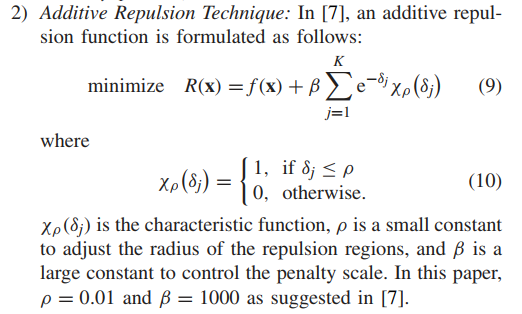

In [38]:
"""Characteristic Function"""
def chi_p(delta_j, rho):
    return 1 if delta_j <= rho else 0

def repulsion_function(f_x,
                       beta=1000,
                       rho=0.01):
    deltas = np.random.uniform(low=0, high=0.02, size=5)
    Rx = f_x + beta * sum(np.exp(-delta_j) * chi_p(delta_j, rho) for delta_j in deltas)
    return Rx

# f_x = root_objective_function(np.array([-6.437160,0.155348]))
# repulsion_function(f_x)

def fitness_function(x,
                     archive,
                     objective_func=root_objective_function,
                     repulsion_func=repulsion_function):
    f_x = objective_func(x)
    if archive == []:
        return f_x
    else:
        return repulsion_func(f_x)

In [41]:
arch = [np.array([1,2]),np.array([3,4]),np.array([5,6])]
x = np.array([-6.437160,0.155348])
print(fitness_function(x,
                       arch,
                       objective_func=root_objective_function,
                       repulsion_func=partial(repulsion_function,beta=1000,rho=0.01)))

2979.0029800297334


In [4]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim: int,
                    npoint:int,
                    low=-10,
                    high=10):
    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')
    if type(low) == int:
        boundaries = [(low,high) for _ in range (dim)]
    elif type(low) == list or type(low) == np.ndarray:
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i],high[i]) for i in range (len(low))]

    # Generate Sobol sequence points
    sobol_points = sobol_seq.i4_sobol_generate(dim, npoint)

    # Scale the Sobol points to fit within the specified boundaries
    scaled_points = []
    for i in range(dim):
        a, b = boundaries[i]
        scaled_dim = a + sobol_points[:, i] * (b - a)
        scaled_points.append(scaled_dim)

    # Transpose the scaled points to get points per dimension
    scaled_points = np.array(list(map(list, zip(*scaled_points))))
    return scaled_points


In [5]:
def update_archive(x: np.ndarray,
                   objective_function,
                   archive,
                   theta,
                   tau_d,
                   s_max):
    """Input"""
    # x : Individual
    # theta : accuracy level
    # tau_d : distance radius
    # s_max : maximum archive size
    # archive : archive
    # s : archive current size

    f_x = objective_function(x)
    s = len(archive) # archive current size

    if f_x < theta: # x is a root
        if s == 0: # archive is empty
            archive.append(x)
            s+=1
        else:
            """Find the closest solution x_prime ∈ archive to x in the decision space"""
            dist_min = np.linalg.norm(x-archive[0])
            idx_min = 0
            x_prime= archive[idx_min]
            for i in range(1,len(archive)): 
                dist = np.linalg.norm(x-archive[i])
                if dist < dist_min:
                    dist_min = dist
                    x_prime = archive[i]
                    idx_min = i
            f_x_prime = root_objective_function(x_prime)
            if dist_min < tau_d: # x and x_prime are too close
                if f_x < f_x_prime:
                    x_prime = x
                    archive[idx_min] = x_prime
            else:
                if s < s_max:
                    archive.append(x)
                    s += 1
                else:       # archive is full
                    if f_x<f_x_prime:
                        x_prime = x
                        archive[idx_min] = x_prime
    return archive


# # Example
# x = np.array([-6.437160,0.155348]) # Individual
# theta = 1e-4 # accuracy level
# tau_d = 1e-1 # distance radius
# s_max = 3 # maximum archive size
# archive = [np.array([0,0]),np.array([1,2]),np.array([-6.4,0])] # archive
# update_archive(x,root_objective_function,archive,theta,tau_d,s_max)

In [6]:
def mutation(xr1,xr2,xr3,scaling_factor):
    donor_vector = xr1 + scaling_factor*(xr2-xr3)
    return donor_vector

def crossover(individual:np.ndarray, honor_vector:np.ndarray):
    trial_vector = np.zeros(shape=individual.shape)
    for j in range (individual.shape[0]):
        rand_j = np.random.random() # a uniformly distributed random number from [0, 1]
        j_rand = np.random.randint(dim+1) #a random integer uniformly generated from {1, . . . , n}
        if (rand_j<CR) | (j == j_rand):
            trial_vector[j] = honor_vector[j]
        else: #(rand_j>=CR) & (j != j_rand)
            trial_vector[j] = individual[j]
    return trial_vector


In [7]:
"""Calculate Euclidean distances and select t closest individuals"""
def subpopulationing(individual, 
                               population, 
                               t): 
    """Input"""
    # individual
    # population
    # t: max number of units in a subpopulation

    """Algorithm"""
    # Calculate the Euclidean distances from the individual to all others in the population
    distances = np.sqrt(np.sum((population - individual) ** 2, axis=1))
    # Get the indices of the individuals with the smallest distances
    closest_indices = np.argsort(distances)[:t]
    # Form the subpopulation with the closest individuals
    subpop = population[closest_indices]
    return subpop

# # Example
# # Assuming P is a numpy array of individuals where each individual is a point in n-dimensional space
# P = np.random.rand(100, 5)  # Example: 100 individuals in a 5-dimensional space
# print(P)
# print("")

# # The number of individuals to select with the smallest Euclidean distances
# t = 5
# # Forming subpopulations for each individual in P
# subpopulations = [select_closest_individuals(xi, P, t) for xi in P]
# print(subpopulations)
# print("")

# # Now subpopulations is a list of numpy arrays, each containing the t closest individuals to each xi in P
# # For example, to access the subpopulation for the first individual in P:
# subpopulation_first_individual = subpopulations[0]
# print(subpopulation_first_individual)

In [8]:
def update_parameter(M_F,
                     M_CR,
                     Hm:int):
    """Input"""
    # MF: Historical memories of scaling factor of DE as F
    # MCR:Historical memories crossover rate of DE as CR
    # Hm: Size of Historical Memories

    # Randomly select an index
    hi = np.random.randint(0, Hm)
    # Generate Fi using the Cauchy distribution with the location parameter MF[hi] and scale 0.1
    Fi = np.random.standard_cauchy() * 0.1 + M_F[hi]
    # Generate CRi using the Gaussian distribution with mean MCR[hi] and standard deviation 0.1
    CRi = np.random.normal(M_CR[hi], 0.1)
    # Ensure CRi is within the range [0, 1]
    CRi = np.clip(CRi, 0, 1)
    return Fi, CRi

# # Coba
# MF = [0.5, 0.6, 0.7, 0.8, 0.9] 
# MCR = [0.1, 0.2, 0.3, 0.4, 0.5]
# update_parameter(MF,MCR,len(MF))

In [9]:
popA = generate_points(dim=dim,
                        npoint=NP,
                        low=boundaries[:,0],
                        high=boundaries[:,1])
f_x = root_objective_function([popA[:,0],popA[:,1]])
M_CR = np.ones(Hm)*0.5
M_F = np.ones(Hm)*0.5
archiveA = []
FEs = NP

In [10]:
np.random.seed(0)
for i in range (NP):
    archiveA = update_archive(x = popA[i],
                              objective_function=root_objective_function,
                              archive=archiveA,
                              theta=theta,
                              tau_d=tau_d,
                              s_max=s_max)
S_F, S_CR = [],[]
subpopA = np.array([subpopulationing(xi, popA, num_l) for xi in popA])
for i in range (NP):
    print("")
    print(f'i={i}')
    F_i,CR_i = update_parameter(M_F,M_CR,Hm)
    """GENERATE: three distinct individuals xr1, xr1, xr1 from the current population randomly"""
    x_i = popA[i]
    popB = subpopA[i].copy()
    pop_ids = np.arange(popB.shape[0])
    indices_to_delete = np.where(np.all(popB == x_i, axis=1))[0] # Ensure that x_i is excluded from the selected subpopulation
    subpop_ids_no_i = np.delete(pop_ids, indices_to_delete, axis=0)
    xr1,xr2,xr3 = popB[np.random.choice(subpop_ids_no_i,3,replace=False)] 

    """MUTATION: Form the donor/mutation vector"""
    dv_i = mutation(xr1,xr2,xr3,F_i)

    """CROSSOVER: The trial vector dv_i is developed either from the elements of the target vector xi or the elements of the donor vector vi"""
    tv_i = crossover(x_i,dv_i)

    """Calculate root_objective_function of the trial function tv_i"""
    F_tv_i = root_objective_function(tv_i)

    """Find the closest solution tv_i_prime in the decision space to tv_i in PopA"""
    print(F_tv_i)


i=0
1249.500568952351

i=1
725724.6139732625

i=2
5508440.984504298

i=3
130958.9950047216

i=4
4355414.167631683

i=5
28127331516328.832

i=6
158243.27647533666

i=7
132055.57188348038

i=8
212623.2440537747

i=9
36450998415.486626

i=10
13.972921044918234

i=11
637712.071749318

i=12
1232457.724714731

i=13
150.49081108011566

i=14
43547115.40766438

i=15
893664.8349842859

i=16
747.2619293793448

i=17
72006625661.2055

i=18
32487.697465458594

i=19
318026.4187424525

i=20
22852109.52247591

i=21
1700673902.7135956

i=22
565497.1754467743

i=23
291114.3880857063

i=24
2490.5992854315264

i=25
121640.81793722791

i=26
18946.036659313064

i=27
436716.6729634245

i=28
7888024.244640829

i=29
54043567.54473439

i=30
9612.758262028992

i=31
23971604.763747815

i=32
995.2835485557171

i=33
13301552610100.066

i=34
6.228383267231237

i=35
365867497.91725945

i=36
130350.17488733091

i=37
143395521.32018995

i=38
12913195.22998551

i=39
1817795.485336826

i=40
210522479.41116285

i=41
11359

C:\Users\ACER\AppData\Local\Temp\ipykernel_16920\1753273625.py:17: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])


In [11]:
root_objective_function(np.array([-6.437160,0.155348]))

7.986484550183325e-12